# Classifier problem - Multiyear
J. Cristiano

In this notebook, I'll solve the issue of sorting good images from bad images.  

The current solution is to use logistic regression on the embedding space of the segmentation models
#### Step 1: Dataset Creation

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from typing import Any, Dict, List, Literal, Union, Type

import torchvision.transforms.v2.functional as F
from torchvision.transforms import v2
from torchvision.transforms.v2._utils import (
    _check_padding_mode_arg,
    _get_fill,
    _setup_fill_arg,
    _FillType,
)
# from PadSquare import PadSquare

class PadSquare(v2.Transform):
    """Pad a non-square input to make it square by padding the shorter side to match the longer side.
    Args:
        fill (number or tuple or dict, optional): Pixel fill value used when the  ``padding_mode`` is constant.
            Default is 0. If a tuple of length 3, it is used to fill R, G, B channels respectively.
            Fill value can be also a dictionary mapping data type to the fill value, e.g.
            ``fill={tv_tensors.Image: 127, tv_tensors.Mask: 0}`` where ``Image`` will be filled with 127 and
            ``Mask`` will be filled with 0.
        padding_mode (str, optional): Type of padding. Should be: constant, edge, reflect or symmetric.
            Default is "constant".

            - constant: pads with a constant value, this value is specified with fill

            - edge: pads with the last value at the edge of the image.

            - reflect: pads with reflection of image without repeating the last value on the edge.
              For example, padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode
              will result in [3, 2, 1, 2, 3, 4, 3, 2]

            - symmetric: pads with reflection of image repeating the last value on the edge.
              For example, padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode
              will result in [2, 1, 1, 2, 3, 4, 4, 3]

    Example:
        >>> import torch
        >>> from torchvision.transforms.v2 import PadSquare
        >>> rectangular_image = torch.randint(0, 255, (3, 224, 168), dtype=torch.uint8)
        >>> transform = PadSquare(padding_mode='constant', fill=0)
        >>> square_image = transform(rectangular_image)
        >>> print(square_image.size())
        torch.Size([3, 224, 224])
    """

    def __init__(
        self,
        fill: Union[_FillType, Dict[Union[Type, str], _FillType]] = 0,
        padding_mode: Literal["constant", "edge", "reflect", "symmetric"] = "constant",
    ):
        super().__init__()

        _check_padding_mode_arg(padding_mode)

        if padding_mode not in ["constant", "edge", "reflect", "symmetric"]:
            raise ValueError(
                "`padding_mode` must be one of 'constant', 'edge', 'reflect' or 'symmetric'."
            )
        self.padding_mode = padding_mode
        self.fill = _setup_fill_arg(fill)

    def _get_params(self, flat_inputs: List[Any]) -> Dict[str, Any]:
        # Get the original height and width from the inputs
        orig_height, orig_width = v2.query_size(flat_inputs)

        # Find the target size (maximum of height and width)
        target_size = max(orig_height, orig_width)

        if orig_height < target_size:
            # Need to pad height
            pad_height = target_size - orig_height
            pad_top = pad_height // 2
            pad_bottom = pad_height - pad_top
            pad_left = 0
            pad_right = 0
        else:
            # Need to pad width
            pad_width = target_size - orig_width
            pad_left = pad_width // 2
            pad_right = pad_width - pad_left
            pad_top = 0
            pad_bottom = 0

        # The padding needs to be in the format [left, top, right, bottom]
        return dict(padding=[pad_left, pad_top, pad_right, pad_bottom])

    def _transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        fill = _get_fill(self.fill, type(inpt))
        return self._call_kernel(
            F.pad,
            inpt,
            padding=params["padding"],
            padding_mode=self.padding_mode,
            fill=fill
        )

In [3]:
coco_roots = ['/work/2021_annot/images',
              '/work/2022_annot/images',
              '/work/2023_annot/images',
              '/work/2024_annot/images']

coco_annFiles = ['/work/2021_annot/2021_annotations.json',
                 '/work/2022_annot/2022_annotations.json',
                 '/work/2023_annot/2023_annotations_corrected.json',
                 '/work/2024_annot/2024_annotations.json']
bad_samples_roots = ['/work/2023_annot/bad_samples/',
                    '/work/2024_annot/bad_samples/',
                    '/work/2021_annot/bad_samples/',
                    '/work/2022_annot/bad_samples/']    


standard_transform = transforms.v2.Compose([
    PadSquare(0), 
    v2.Resize((512, 512)), 
    v2.ToImage()
    ])
# First wrap the dataset with the new taggable key
full_dataset = datasets.CocoDetection(root=coco_roots[0], annFile=coco_annFiles[0], transforms=standard_transform)
full_dataset = datasets.wrap_dataset_for_transforms_v2(full_dataset, target_keys=("labels", "masks"))
classifier_dataset = datasets.ImageFolder(root=bad_samples_roots[0], transform=standard_transform)
for coco_root, coco_annFile, bad_sample_root in zip(coco_roots[1:], coco_annFiles[1:], bad_samples_roots[1:]):
    seasonal_dataset = datasets.CocoDetection(root=coco_root, annFile=coco_annFile, transforms=standard_transform)
    seasonal_dataset = datasets.wrap_dataset_for_transforms_v2(seasonal_dataset, target_keys=("labels", "masks"))
    full_dataset = torch.utils.data.ConcatDataset([full_dataset, seasonal_dataset])
    seasonal_classifier_dataset = datasets.ImageFolder(root=bad_sample_root, transform=standard_transform) 
    classifier_dataset = torch.utils.data.ConcatDataset([classifier_dataset, seasonal_classifier_dataset])
    indices = torch.randperm(len(full_dataset)).tolist()
    full_dataset = torch.utils.data.Subset(full_dataset, indices)
# Add labels to the classifier_dataset
classifier_dataset = [(img, 0) for img, _ in classifier_dataset]
#sort the taggable images from the annotation dataset
for i in tqdm(range(len(full_dataset))):
    labels = full_dataset[i][1]["labels"]
    # print(labels)
    taggable = (len(torch.unique(labels)) == 3)
    # print(f"Taggable: {taggable}")
    if taggable:
        classifier_dataset.append((full_dataset[i][0], 1))
    else:
        classifier_dataset.append((full_dataset[i][0], 0))
train_size = int(0.8 * len(classifier_dataset))
test_size = int(0.2 * len(classifier_dataset))
test_size += len(classifier_dataset) - (train_size + test_size)
print(f"Train size: {train_size}, Test size: {test_size}")
classifier_dataset_train, classifier_dataset_test = torch.utils.data.random_split(classifier_dataset, [train_size, test_size])
# Now we can use the classifier_dataset for training
del full_dataset

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 412/412 [01:09<00:00,  5.95it/s]

Train size: 523, Test size: 131


Next, I will obtain a mix of 74 bad photos and put them in a sub folder, creating a new classifier dataset. 


In [4]:
!pip install segmentation_models_pytorch

In [5]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch.nn as nn
preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
model = smp.Unet('resnet34', encoder_weights='imagenet', in_channels=3, classes=4, activation=None)
model.load_state_dict(torch.load('/work/multiclass_multiyear_UNET_sm.pth', map_location=device,weights_only=True))
model = model.to(device)

In [6]:
!pip install scikit-learn

In [7]:
# TODO: bring in the CLIP example to show improvements over it
import os
# import clip
from sklearn.linear_model import LogisticRegression
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.model_selection import GridSearchCV
def get_UNET_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=1)):
            img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in images])
            img = img.permute(0, 3, 1, 2).float()
            result = model.encoder(img.to(device))
            features = result[-1]
            # Get the batch size and space size dynamically
            batch_size, space_size, _, _ = features.shape
            #tried max pooling instead of average pooling, it didn't work
            flattened_tensor = features.view(batch_size, space_size, -1).mean(dim=-1)
            all_features.append(flattened_tensor.cpu())
            all_labels.append(labels)

    return torch.cat(all_features).numpy(), torch.cat(all_labels).numpy()

train_x, train_y = get_UNET_features(classifier_dataset_train)
test_x, test_y = get_UNET_features(classifier_dataset_test)

# Define the parameter grid
param_grid = {'C': np.logspace(-4, 4, 20)}

# Initialize the logistic regression model
logistic = LogisticRegression(random_state=0, max_iter=10000)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(logistic, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(train_x, train_y)

# Get the best parameter and the best score
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"Best C: {best_C}")
print(f"Best cross-validation accuracy: {best_score:.3f}")

# Evaluate using the best logistic regression classifier
best_classifier = grid_search.best_estimator_
predictions = best_classifier.predict(test_x)
accuracy = np.mean((test_y == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")

# Save the best classifier


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 225.92it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best C: 29.763514416313132
Best cross-validation accuracy: 0.931
Test accuracy = 92.366


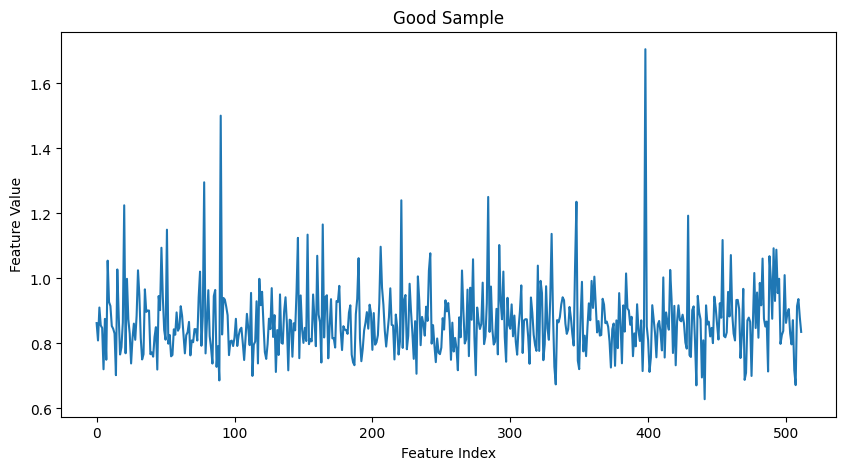

In [8]:
# print(train_x[1], train_y[2]) 

plt.figure(figsize=(10, 5))
plt.plot(train_x[0])
plt.title('Good Sample')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_x[2])
plt.title('Bad Sample')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

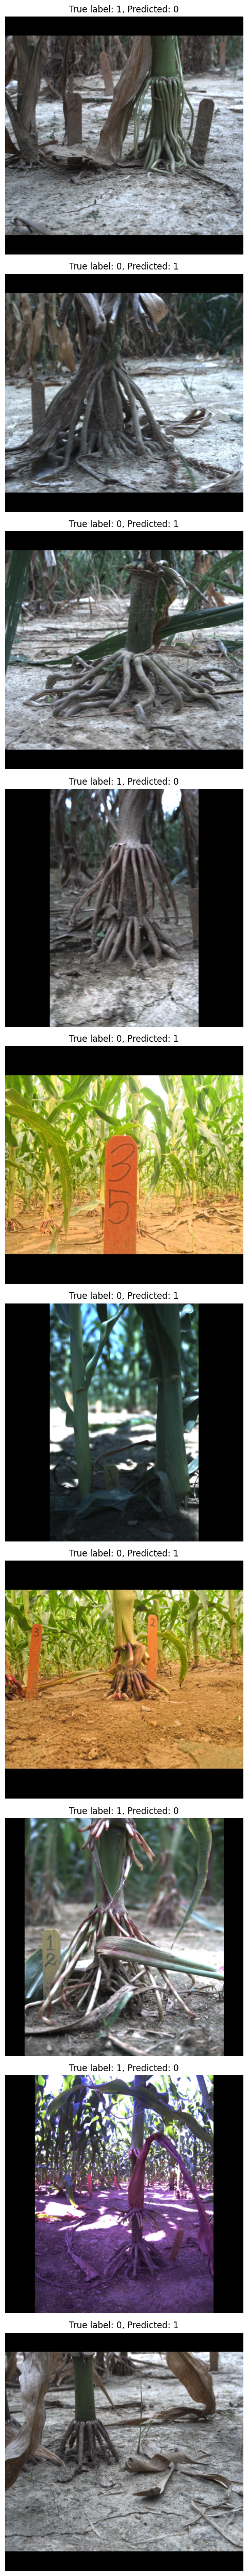

In [9]:
# Find the indices of incorrect predictions
incorrect_indices = np.where(test_y != predictions)[0]

# Plot the incorrect predictions
fig, axes = plt.subplots(len(incorrect_indices), 1, figsize=(10, len(incorrect_indices) * 5))

for idx, incorrect_idx in enumerate(incorrect_indices):
    image, label = classifier_dataset_test[incorrect_idx]
    axes[idx].imshow(image.permute(1, 2, 0))
    axes[idx].set_title(f"True label: {test_y[incorrect_idx]}, Predicted: {predictions[incorrect_idx]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### New Classifiers 
Starting with SVM

In [10]:
# We still have train_x and train_y, so we can use them to train a new model
from sklearn import svm
svm_model = svm.SVC(kernel='poly', random_state=0, max_iter=10000)
svm_grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=1, n_jobs=-1)
svm_grid_search.fit(train_x, train_y)
# Get the best parameter and the best score
svm_best_C = svm_grid_search.best_params_['C']
svm_best_score = svm_grid_search.best_score_
print(f"SVM Best C: {svm_best_C}")
print(f"SVM Best cross-validation accuracy: {svm_best_score:.3f}")
# Evaluate using the best svm classifier
best_svm = svm_grid_search.best_estimator_
predictions = best_svm.predict(test_x)
accuracy = np.mean((test_y == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVM Best C: 0.0006951927961775605
SVM Best cross-validation accuracy: 0.933
Test accuracy = 92.366


In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, verbose=1, n_jobs=-1)
knn_grid_search.fit(train_x, train_y)
# Get the best parameter and the best score
knn_best_C = knn_grid_search.best_params_      
knn_best_score = knn_grid_search.best_score_
print(f"KNN Best C: {knn_best_C}")
print(f"KNN Best cross-validation accuracy: {knn_best_score:.3f}")
# Evaluate using the best knn classifier
best_knn = knn_grid_search.best_estimator_
predictions = best_knn.predict(test_x)
accuracy = np.mean((test_y == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNN Best C: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
KNN Best cross-validation accuracy: 0.912
Test accuracy = 91.603


In [12]:
#simple NN 
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size=512, hidden_size=1024):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return self.sigmoid(x)
        # return x

model_nn = SimpleNN().to(device)
print(model_nn)

SimpleNN(
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [13]:
from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim

# Convert train_x and train_y to tensors
train_tensor_x = torch.from_numpy(train_x).float()  # shape should match (N, 512)
train_tensor_y = torch.from_numpy(train_y).float().unsqueeze(1)  # shape (N, 1) for BCELoss

# Create dataset and loader
train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Set up loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=1e-4)
num_epochs = 2000

# Training loop
model_nn.train()
pocket_model = model_nn
pocket_loss = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model_nn(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    epoch_loss = running_loss / len(train_dataset)
    if epoch_loss < pocket_loss:
        pocket_model = model_nn
        pocket_loss = epoch_loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

/opt/sam2_env/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Epoch 1/2000, Loss: 0.6873
Epoch 2/2000, Loss: 0.6887
Epoch 3/2000, Loss: 0.6772
Epoch 4/2000, Loss: 0.6777
Epoch 5/2000, Loss: 0.6747
Epoch 6/2000, Loss: 0.6757
Epoch 7/2000, Loss: 0.6753
Epoch 8/2000, Loss: 0.6786
Epoch 9/2000, Loss: 0.6773
Epoch 10/2000, Loss: 0.6740
Epoch 11/2000, Loss: 0.6729
Epoch 12/2000, Loss: 0.6838
Epoch 13/2000, Loss: 0.6767
Epoch 14/2000, Loss: 0.6755
Epoch 15/2000, Loss: 0.6744
Epoch 16/2000, Loss: 0.6716
Epoch 17/2000, Loss: 0.6680
Epoch 18/2000, Loss: 0.6671
Epoch 19/2000, Loss: 0.6651
Epoch 20/2000, Loss: 0.6671
Epoch 21/2000, Loss: 0.6645
Epoch 22/2000, Loss: 0.6629
Epoch 23/2000, Loss: 0.6609
Epoch 24/2000, Loss: 0.6575
Epoch 25/2000, Loss: 0.6598
Epoch 26/2000, Loss: 0.6541
Epoch 27/2000, Loss: 0.6561
Epoch 28/2000, Loss: 0.6661
Epoch 29/2000, Loss: 0.6471
Epoch 30/2000, Loss: 0.6475
Epoch 31/2000, Loss: 0.6410
Epoch 32/2000, Loss: 0.6502
Epoch 33/2000, Loss: 0.6477
Epoch 34/2000, Loss: 0.6374
Epoch 35/2000, Loss: 0.6402
Epoch 36/2000, Loss: 0.6323
E

Epoch 119/2000, Loss: 0.3305
Epoch 120/2000, Loss: 0.3533
Epoch 121/2000, Loss: 0.3423
Epoch 122/2000, Loss: 0.3494
Epoch 123/2000, Loss: 0.3079
Epoch 124/2000, Loss: 0.3057
Epoch 125/2000, Loss: 0.3076
Epoch 126/2000, Loss: 0.3000
Epoch 127/2000, Loss: 0.2987
Epoch 128/2000, Loss: 0.3040
Epoch 129/2000, Loss: 0.4091
Epoch 130/2000, Loss: 0.3276
Epoch 131/2000, Loss: 0.2888
Epoch 132/2000, Loss: 0.3180
Epoch 133/2000, Loss: 0.2867
Epoch 134/2000, Loss: 0.3109
Epoch 135/2000, Loss: 0.3017
Epoch 136/2000, Loss: 0.3043
Epoch 137/2000, Loss: 0.2991
Epoch 138/2000, Loss: 0.2851
Epoch 139/2000, Loss: 0.3204
Epoch 140/2000, Loss: 0.2949
Epoch 141/2000, Loss: 0.2936
Epoch 142/2000, Loss: 0.3259
Epoch 143/2000, Loss: 0.2758
Epoch 144/2000, Loss: 0.3044
Epoch 145/2000, Loss: 0.2942
Epoch 146/2000, Loss: 0.2872
Epoch 147/2000, Loss: 0.2990
Epoch 148/2000, Loss: 0.2718
Epoch 149/2000, Loss: 0.2781
Epoch 150/2000, Loss: 0.3307
Epoch 151/2000, Loss: 0.3030
Epoch 152/2000, Loss: 0.2804
Epoch 153/2000

In [14]:
import copy
pocket_model = copy.deepcopy(model_nn)
model_nn.eval()
predictions = model_nn(torch.from_numpy(test_x).float().to(device))
# predictions = torch.sigmoid(predictions)
predictions = predictions.cpu().detach().numpy()
predictions = np.round(predictions).flatten()
accuracy = np.mean((test_y == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")


Test accuracy = 87.786


In [15]:
# _MODELS = {
#     "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
#     "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
#     "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
#     "RN50x16": "https://openaipublic.azureedge.net/clip/models/52378b407f34354e150460fe41077663dd5b39c54cd0bfd2b27167a4a06ec9aa/RN50x16.pt",
#     "RN50x64": "https://openaipublic.azureedge.net/clip/models/be1cfb55d75a9666199fb2206c106743da0f6468c9d327f3e0d0a543a9919d9c/RN50x64.pt",
#     "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
#     "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
#     "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
#     "ViT-L/14@336px": "https://openaipublic.azureedge.net/clip/models/3035c92b350959924f9f00213499208652fc7ea050643e8b385c2dac08641f02/ViT-L-14-336px.pt",
# }

from torch.utils.data import Dataset
class WrapperDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data  # List of (image, label) tuples
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

In [16]:
# Calculate the image features
import clip
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset

def get_clip_features(dataset):
    all_features = []
    all_labels = []
    print(f"Dataset size: {len(dataset)}")
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=4)):
            
            features = model.encode_image(images.to(device))
            # print(f"Batch {i}, features shape: {features.shape}, labels: {labels}")
    
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

print(f"Classifier dataset size: {len(classifier_dataset)}")
# Calculate the image features



# datasets are a list of tuples (image, label)
# transforms are not getting applied
# need to convert back to a dataset object. 
combined_transform = transforms.v2.Compose([transforms.v2.ToPILImage(), preprocess])
wrapped_train_dataset = WrapperDataset(classifier_dataset_train, transform=combined_transform)
wrapped_test_dataset = WrapperDataset(classifier_dataset_test, transform=combined_transform)


# classifier_dataset_train.transform = preprocess
# classifier_dataset_test.transform = preprocess
train_features, train_labels = get_clip_features(wrapped_train_dataset)
test_features, test_labels = get_clip_features(wrapped_test_dataset)

# # Perform logistic regression
# classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
# classifier.fit(train_features, train_labels)

# # Evaluate using the logistic regression classifier
# predictions = classifier.predict(test_features)
# accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
# print(f"Accuracy = {accuracy:.3f}")
# Define the parameter grid
param_grid = {'C': np.logspace(-4, 4, 20)}

# Initialize the logistic regression model
logistic = LogisticRegression(random_state=0, max_iter=10000)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(logistic, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(train_features, train_labels)

# Get the best parameter and the best score
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"Best C: {best_C}")
print(f"Best cross-validation accuracy: {best_score:.3f}")

# Evaluate using the best logistic regression classifier
best_classifier = grid_search.best_estimator_
predictions = best_classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")



Classifier dataset size: 654
Dataset size: 523


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [00:01<00:00, 82.70it/s]


Dataset size: 131


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 89.78it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best C: 0.23357214690901212
Best cross-validation accuracy: 0.945
Test accuracy = 91.603


In [17]:
# We still have train_x and train_y, so we can use them to train a new model
from sklearn import svm
svm_model = svm.SVC(kernel='poly', random_state=0, max_iter=10000)
svm_grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=1, n_jobs=-1)
svm_grid_search.fit(train_features, train_labels)
# Get the best parameter and the best score
svm_best_C = svm_grid_search.best_params_['C']
svm_best_score = svm_grid_search.best_score_
print(f"SVM Best C: {svm_best_C}")
print(f"SVM Best cross-validation accuracy: {svm_best_score:.3f}")
# Evaluate using the best svm classifier
best_svm = svm_grid_search.best_estimator_
predictions = best_svm.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVM Best C: 1.623776739188721
SVM Best cross-validation accuracy: 0.946
Test accuracy = 93.130


In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, verbose=1, n_jobs=-1)
knn_grid_search.fit(train_features, train_labels)
# Get the best parameter and the best score
knn_best_C = knn_grid_search.best_params_      
knn_best_score = knn_grid_search.best_score_
print(f"KNN Best C: {knn_best_C}")
print(f"KNN Best cross-validation accuracy: {knn_best_score:.3f}")
# Evaluate using the best knn classifier
best_knn = knn_grid_search.best_estimator_
predictions = best_knn.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNN Best C: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
KNN Best cross-validation accuracy: 0.929
Test accuracy = 93.130
